# Are nonprofits with a fee for service model more resilient? 

In [4]:
%%HTML
<style type="text/css">
</style>


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime as dt
import seaborn as sns
import janitor #pyjanitor 
import statsmodels.formula.api as smf
import censusdata 
import plotly.graph_objects as go

pd.set_option('display.max_colwidth', 110)
%matplotlib inline

# This tells us where the csv files are located in the system
from irsx.settings import INDEX_DIRECTORY
INDEX_DIRECTORY

'C:\\Users\\tenis\\anaconda3\\lib\\site-packages\\irsx\\CSV'

In [6]:
rawdata = pd.read_csv("data/Open990_Governance_Snack_Set_Public_2019-01-15.csv").clean_names()

C:\Users\tenis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 10)
pd.set_option('display.min_rows', 10)

rawdata

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form_association,org_form_corp,org_form_other_form,org_form_other_form_desc,org_form_trust,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status_501c3,exempt_status_501c_any,exempt_status_501c_txt,gross_receipts,ntee_code_nccs,ntee_description_nccs,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,operate_hospfacility,relationsamongemployees,delegate_management,material_diversion,memb_or_stockholder,memb_elect_board,decisions_outside_board,govern_body_minutes,committee_minutes,no_officer_address,local_chapt,policies_ref_chapt,990_to_members,conflict_interest_policy,conflict_disclosure,enforce_conflict_policy,whistleblower_policy,doc_retention_policy,ceo_comp_review,officer_comp_review,in_joint_venture,joint_venture_policy,forms_ownwebsite,comp_currkeypersons_tot,cash_noninterest_endyr,savingtempcash_endyr,pledges_net_endyr,accountreceivable_net_endyr,invest_publicsec_endyr,invest_othersec_endyr,invest_prog_endyr,asset_intangible_endyr,asset_unrestrictnet_endyr,asset_temprestrictnet_endyr,asset_permrestrictnet_endyr,record_id,schema_version,irs_efile_id,random_string
0,391546606,DAYSTAR INC,2017-01-01,2017-12-31,2017,NaN,+1 (414) 385-0334,WWW.DAYSTARINC.ORG,PO BOX 2130,MILWAUKEE,WI,NaN,532012130,NaN,True,NaN,NaN,NaN,1986.0,NaN,WI,no,NaN,True,NaN,NaN,333897,NaN,NaN,NaN,9,9,8,25.0,4280,0.0,207987.0,6092.0,1.0,-143.0,213937.0,0.0,0.0,140200.0,0.0,21971,92928.0,233128.0,-19191.0,316735.0,288974.0,27761.0,260639,8695,0,4280,273614,0,0,115568,0,115084,230652,42962,325654,254931,70723,no,no,no,no,no,no,no,yes,yes,no,no,NaN,yes,yes,yes,yes,yes,yes,yes,no,no,NaN,NaN,16375.0,27988.0,201.0,17998.0,6009.0,NaN,NaN,NaN,NaN,70723.0,0.0,NaN,391546606_201712,2017v2.2,201831219349300733,MTA0MDA1NjUyMDM1ODQ2NDI1MQ
1,640901077,HERNANDO MAIN STREETCHAMBER OF COMMERCE,2012-01-01,2012-12-31,2012,NaN,+1 (662) 429-9055,www.hernandoms.org,2440 HIGHWAY 51 SOUTH,HERNANDO,MS,NaN,38632,NaN,True,NaN,NaN,NaN,1973.0,NaN,MS,no,no,NaN,True,6.0,252283,S41,Promotion of Business,NaN,15,15,4,NaN,0,NaN,92322.0,4740.0,649.0,18732.0,116443.0,NaN,NaN,87063.0,NaN,-103606,81181.0,168244.0,-51801.0,89517.0,7271.0,82246.0,81249,40715,296,26417,148677,965,0,83768,0,76994,161727,-13050,72742,3546,69196,no,no,no,no,yes,yes,yes,yes,no,no,no,NaN,yes,yes,yes,yes,no,no,no,no,no,NaN,NaN,45010.0,30403.0,34216.0,0.0,6738.0,0.0,0.0,0.0,0.0,69196.0,NaN,NaN,640901077_201212,2012v2.0,201321359349303692,MTA0MDA1NzYwNzM0ODkyMTY0Ng
2,522113016,MARYLAND CAPITAL ENTERPRISES INC,2014-10-01,2015-09-30,2015,NaN,+1 (410) 546-1900,WWW.MARYLANDCAPITAL.ORG,PO BOX 213,SALISBURY,MD,NaN,21802,NaN,True,NaN,NaN,NaN,1991.0,NaN,MD,no,NaN,True,NaN,NaN,1406736,P51,"Financial Counseling, Money Management",NaN,15,15,16,0.0,0,0.0,1324919.0,0.0,170539.0,59726.0,1555184.0,0.0,0.0,337154.0,0.0,0,589747.0,926901.0,628283.0,4376943.0,2518702.0,1858241.0,1091077,0,257136,51865,1400078,0,0,517577,0,386300,903877,496201,5435095,3080653,2354442,no,no,no,no,no,no,no,yes,yes,no,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,no,NaN,NaN,28139.0,486696.0,802607.0,119721.0,NaN,NaN,NaN,NaN,NaN,1915868.0

# Data cleaning 

In [9]:
df = rawdata 

# Selecting only 2017 tax_yr
df = df.loc[df['tax_yr'] == 2017]

#Drop variables not valuable for our analysis
df = df.drop([
                'tax_yr',
                'doing_business_as',
                'phone',
                'website',
                'address',
                'relationsamongemployees', #Here I took out part 6
                'delegate_management',
                'material_diversion',
                'memb_or_stockholder',
                'memb_elect_board',
                'decisions_outside_board',
                'govern_body_minutes',
                'committee_minutes',
                'no_officer_address',
                'local_chapt',
                'policies_ref_chapt',
                '990_to_members',
                'conflict_interest_policy',
                'conflict_disclosure',
                'enforce_conflict_policy',
                'whistleblower_policy',
                'doc_retention_policy',
                'ceo_comp_review',
                'officer_comp_review',
                'in_joint_venture',
                'joint_venture_policy',
                'forms_ownwebsite', #This is the end of part 6 
                'state_legaldomicile'
               ], axis=1)


# Revenue Breakdown 

In [10]:

# Selecting only the relevant columns
rev = df[['ein',
            'name_org',
            'city',
            'state',
            'country',
            'zip',
            'org_form_association',
            'org_form_corp',
            'org_form_other_form',
            'org_form_other_form_desc',
            'org_form_trust',
            'rev_giftsgrants_tot_curyr',
            'rev_prgmservice_curyr',
            'rev_investmt_curyr',
            'rev_other_curyr',
            'rev_tot_curyr',
            'grants_expense_tot_curyr',
            'benefits_expense_tot_curyr',
            'salaries_expense_tot_curyr',
            'fundraiseservfee_expense_tot_curyr',
            'other_expense_tot_curyr',
            'expense_tot_curyr',
            'rev_less_expense_curyr'
            ]]
#Melting the organization form columns
rev = pd.melt(rev, id_vars =['ein',
            'name_org',
            'city',
            'state',
            'country',
            'zip',
            'org_form_other_form_desc',
            'rev_giftsgrants_tot_curyr',
            'rev_prgmservice_curyr',
            'rev_investmt_curyr',
            'rev_other_curyr',
            'rev_tot_curyr',
            'grants_expense_tot_curyr',
            'benefits_expense_tot_curyr',
            'salaries_expense_tot_curyr',
            'fundraiseservfee_expense_tot_curyr',
            'other_expense_tot_curyr',
            'expense_tot_curyr',
            'rev_less_expense_curyr'], value_vars =['org_form_association','org_form_corp','org_form_other_form','org_form_trust'], var_name = 'organization_form', value_name='to_delete' ) 

#Removing the NAs from org form and deleting the to_delete column
rev.dropna(subset = ["to_delete"], inplace = True)
rev = rev.drop(["to_delete"], axis=1)

#Renaming the column values of organization form 
rev['organization_form'] = rev['organization_form'].str.replace('org_form_association', 'Association')
rev['organization_form'] = rev['organization_form'].str.replace('org_form_trust', 'Trust')
rev['organization_form'] = rev['organization_form'].str.replace('org_form_other_form', 'Other')
rev['organization_form'] = rev['organization_form'].str.replace('org_form_corp', 'Corporation')
rev

,ein,name_org,city,state,country,zip,org_form_other_form_desc,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,organization_form
57,141637156,EPILEPSY FOUNDATION OF NORTHEASTERN NEW YORK INC,ALBANY,NY,NaN,12205,NaN,688158,550872,25918,0,1264948,0,0,983405,0,313109,1296514,-31566,Association
83,911864761,SUNRISE WATER ASSOCIATION,OTHELLO,WA,NaN,99344,NaN,31450,109640,14,1480,142584,0,0,0,0,98399,98399,44185,Association
90,263145535,TEXAS HORSE ORGANIZATION FOR RACING SHOWING & EVENTING,FORT WORTH,TX,NaN,76107,NaN,0,0,0,0,0,0,0,0,0,1141,1141,-1141,Association
109,366095737,GEORGE W BENJAMIN POST 791 OF THE AMERICAN LEGION,NORTHBROOK,IL,NaN,600651068,NaN,6098,0,18673,0,24771,0,0,0,0,79305,79305,-54534,Association
119,720654140,ACADIAN HOME BUILDERS ASSOCIATION INC,LAFAYETTE,LA,NaN,705960486,NaN,372049,0,5865,113656,491570,8111,0,143159,0,327206,478476,13094,Association
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713970,596152618,PLUMBERS & PIPEFITTERS LOCAL UNION NO 803 HEALTH AND WELFARE FUND,JACKSONVILLE,FL,NaN,32256,NaN,0,4036435,103295,0,4139730,0,3332914,0,0,199045,3531959,607771,Trust
713971,566045828,EDWARD K BISHOP TUW,WILSON,NC,NaN,278942907,NaN,0,0,53212,0,53212,53132,0,21463,0,1138,75733,-22521,Trust
713980,556094364,NATURAL SCIENCE ENDOWMENT FUND BRADFORD,WILSON,NC,NaN,278942907,NaN,0,0,62916,0,62916,61058,0,5941,0,1000,67999,-5083,Trust
713999,860062925,ROTARY CLUB OF TUCSON,TUCSON,AZ,NaN,85711,NaN,311296,0,166,7484,318946,0,0,77392,0,227212,304604,14342,Trust


In [11]:
#Grouping nonprofit types, then aggregating summary statistics, resetting the index, renaming the sum column, and then joining the totals into one data frame
grouped_gifts = rev.groupby('organization_form')['rev_giftsgrants_tot_curyr'].agg(['mean','median','sem', 'min', 'max','sum']).reset_index().rename(columns={"sum": "Total Gifts and Grants Revenue","mean": "Mean Gifts and Grants Revenue","sem": "sem Gifts and Grants Revenue","median": "Median Gifts and Grants"})
grouped_gifts = grouped_gifts[['organization_form',"Mean Gifts and Grants Revenue","sem Gifts and Grants Revenue","Median Gifts and Grants",'Total Gifts and Grants Revenue']]

grouped_service = rev.groupby('organization_form')['rev_prgmservice_curyr'].agg(['mean','median','sem', 'min', 'max','sum']).reset_index().rename(columns={"sum": "Total Service Revenue","mean": "Mean Service","sem": "sem Service", "median": "Median Service"})
grouped_service = grouped_service[['organization_form',"Mean Service","sem Service","Median Service",'Total Service Revenue']]

grouped_investment = rev.groupby('organization_form')['rev_investmt_curyr'].agg(['mean','median','sem', 'min', 'max','sum']).reset_index().rename(columns={"sum": "Total Investment Revenue","mean": "Mean Investments","sem": "sem Investments","median": "Median Investments"})
grouped_investment = grouped_investment[['organization_form','Mean Investments',"sem Investments",'Median Investments','Total Investment Revenue']]

grouped_other = rev.groupby('organization_form')['rev_other_curyr'].agg(['mean','median','sem', 'min', 'max','sum']).reset_index().rename(columns={"sum": "Total Other Revenue","mean": "Mean Other","sem": "sem Other","median": "Median Other"})
grouped_other = grouped_other[['organization_form',"Mean Other",'sem Other','Median Other','Total Other Revenue']]

grouped_total = rev.groupby('organization_form')['rev_tot_curyr'].agg(['mean','median','sem', 'min', 'max','sum']).reset_index().rename(columns={"sum": "Total Revenue","mean": "Mean Total","sem": "sem Total", "median": "Median Total"})
grouped_total = grouped_total[['organization_form',"Mean Total","sem Total",'Median Total','Total Revenue']]

grouped_rev = pd.merge(grouped_gifts,
                 grouped_service,
                 on='organization_form', 
                 how='left')

grouped_rev = pd.merge(grouped_rev,
                 grouped_investment,
                 on='organization_form', 
                 how='left')

grouped_rev = pd.merge(grouped_rev,
                 grouped_other,
                 on='organization_form', 
                 how='left')

grouped_rev = pd.merge(grouped_rev,
                 grouped_total,
                 on='organization_form', 
                 how='left')

#Creating percent variables 
grouped_rev['Percent Gifts and Grants'] = grouped_rev['Total Gifts and Grants Revenue'] / grouped_rev['Total Revenue']
grouped_rev['Percent Service'] = grouped_rev['Total Service Revenue'] / grouped_rev['Total Revenue']
grouped_rev['Percent Investments'] = grouped_rev['Total Investment Revenue'] / grouped_rev['Total Revenue']
grouped_rev['Percent Other'] = grouped_rev['Total Other Revenue'] / grouped_rev['Total Revenue']

grouped_rev


,organization_form,Mean Gifts and Grants Revenue,sem Gifts and Grants Revenue,Median Gifts and Grants,Total Gifts and Grants Revenue,Mean Service,sem Service,Median Service,Total Service Revenue,Mean Investments,sem Investments,Median Investments,Total Investment Revenue,Mean Other,sem Other,Median Other,Total Other Revenue,Mean Total,sem Total,Median Total,Total Revenue,Percent Gifts and Grants,Percent Service,Percent Investments,Percent Other
0,Association,2.650789e+05,1.852880e+04,15626,2182129703,1.691929e+06,288989.503844,115892.5,13927959500,240771.502672,164099.858397,331.5,1982031010,99927.063776,11242.005575,2554.5,822599589,2.297706e+06,4.043773e+05,295370,18914719802,0.115367,0.736356,0.104788,0.043490
1,Corporation,2.103336e+06,7.202460e+04,142280,332560568384,6.235783e+06,214455.519725,94385.0,985945891545,413226.073676,32291.681208,346.0,65335587735,217956.136803,9695.250867,1325.0,34461262746,8.970301e+06,2.634548e+05,509375,1418303310410,0.234478,0.695159,0.046066,0.024298
2,Other,1.181597e+06,2.452795e+05,13913,5015878401,3.141285e+06,397584.653924,103662.0,13334754309,354365.419788,118910.381506,679.0,1504281207,173368.234393,39794.188252,1433.0,735948155,4.850615e+06,5.837011e+05,380070,20590862072,0.243597,0.647605,0.073056,0.035741
3,Trust,2.103273e+06,1.402204e+06,0,10428028640,1.011269e+07,734214.906587,274258.5,50138721024,780704.637555,153094.295480,29567.0,3870733593,148627.845906,32747.018355,0.0,736896860,1.314530e+07,1.696193e+06,657658,65174380117,0.160002,0.769301,0.059390,0.011307


# Total Revenue 

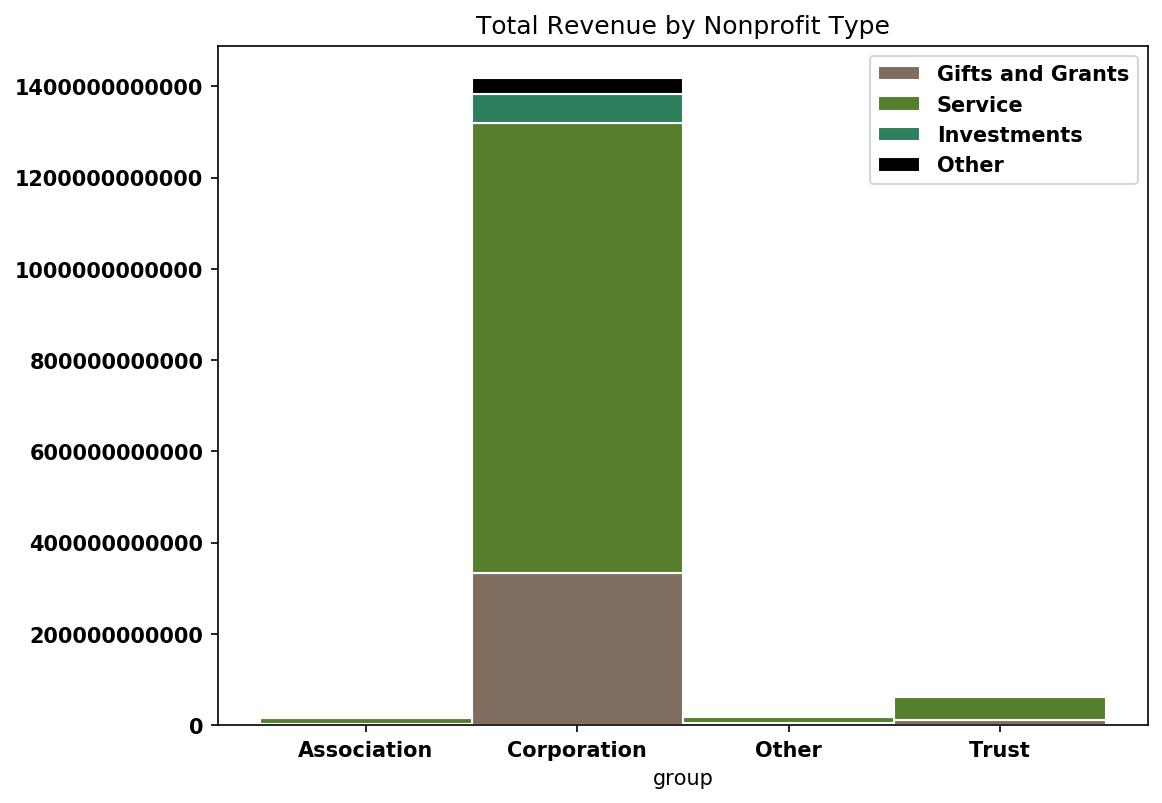

In [12]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter 
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

#Matplotlib stacked barchart
# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = grouped_rev['Total Gifts and Grants Revenue']
bars2 = grouped_rev['Total Service Revenue']
bars3 = grouped_rev['Total Investment Revenue']
bars4 = grouped_rev['Total Other Revenue']

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
bars_2 = np.add(bars, bars3).tolist()

# The position of the bars on the x-axis
r = [0,1,2,3]

# Names of group and bar width
names = ['Association','Corporation','Other','Trust']
barWidth = 1

# Create brown bars
bars11 = plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
bars21 = plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)
# Create green bars (top)
bars31 = plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
# Create green bars (top)
bars41 =plt.bar(r, bars4, bottom=bars_2, color='#000000', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")

#Custom Y axis
plt.ticklabel_format(style='plain', axis='y')

#Custom legend 
plt.legend([bars11, bars21, bars31, bars41], ['Gifts and Grants','Service','Investments','Other'])
plt.title("Total Revenue by Nonprofit Type")

# Show graphic
plt.show()
#Top is 140 billion

# Total distribution of revenue streams

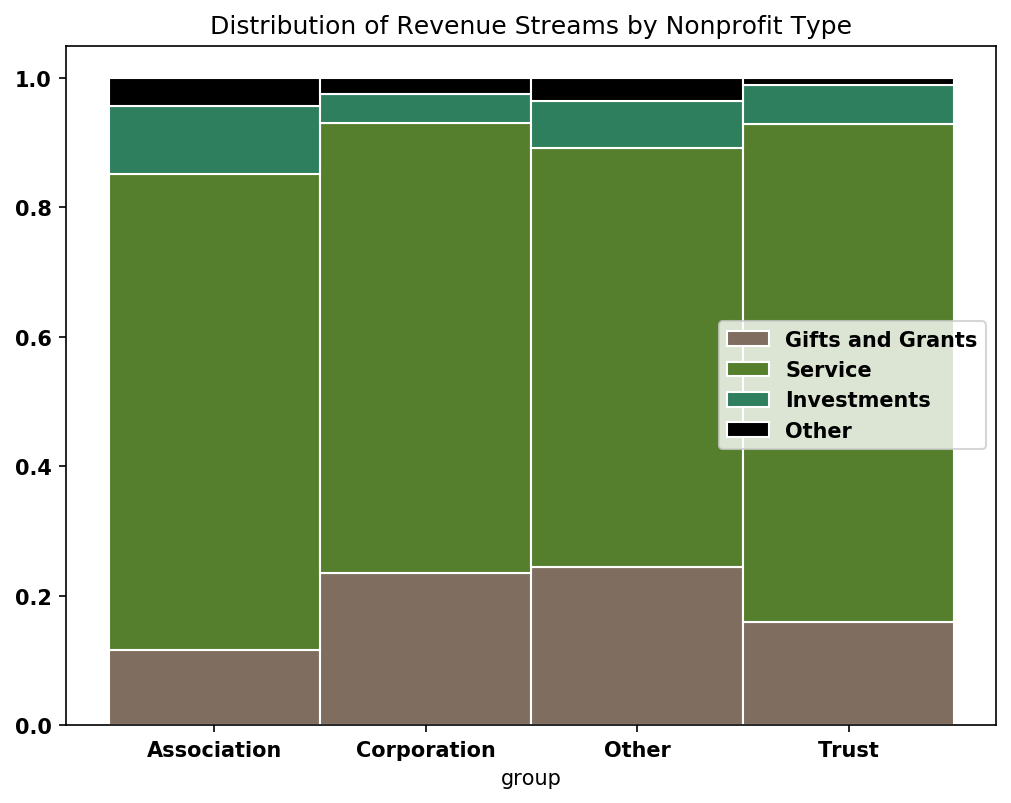

In [13]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

#Matplotlib stacked barchart
# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = grouped_rev['Percent Gifts and Grants']
bars2 = grouped_rev['Percent Service']
bars3 = grouped_rev['Percent Investments']
bars4 = grouped_rev['Percent Other']

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
bars_2 = np.add(bars, bars3).tolist()

# The position of the bars on the x-axis
r = [0,1,2,3]

# Names of group and bar width
names = ['Association','Corporation','Other','Trust']
barWidth = 1

# Create brown bars
bars11 = plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
bars21 = plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)
# Create green bars (top)
bars31 = plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
# Create green bars (top)
bars41 =plt.bar(r, bars4, bottom=bars_2, color='#000000', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
plt.legend([bars11, bars21, bars31, bars41], ['Gifts and Grants','Service','Investments','Other'])
plt.title("Distribution of Revenue Streams by Nonprofit Type")
# Show graphic
plt.show()


# Median Revenue Stream by nonprofit type

C:\Users\tenis\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 15.330624999999998, '')

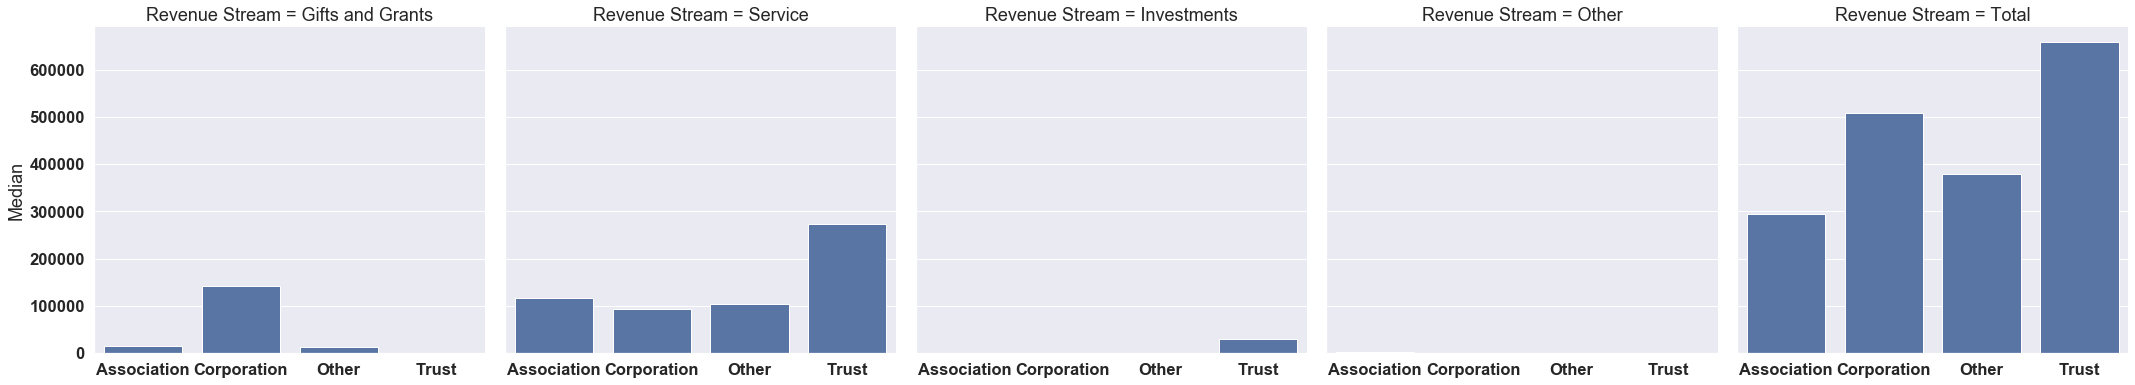

In [14]:
median_rev = grouped_rev[['organization_form', 'Median Gifts and Grants','Median Service','Median Investments','Median Other', 'Median Total' ]].rename(columns={"Median Gifts and Grants": "Gifts and Grants","Median Service": "Service", "Median Investments": "Investments", "Median Other": "Other", "Median Total": "Total"})
median_rev=pd.melt(median_rev,id_vars=['organization_form'],var_name='Revenue Stream', value_name='Median')


sns.set(font_scale=1.5) 
g = sns.FacetGrid(median_rev, col="Revenue Stream", height = 6, aspect  = 1)
g = g.map(sns.barplot, "organization_form", "Median")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,2].set_xlabel('')
g.axes[0,3].set_xlabel('')
g.axes[0,4].set_xlabel('')

# Median Revenue Streams minus the total

C:\Users\tenis\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 15.330624999999998, '')

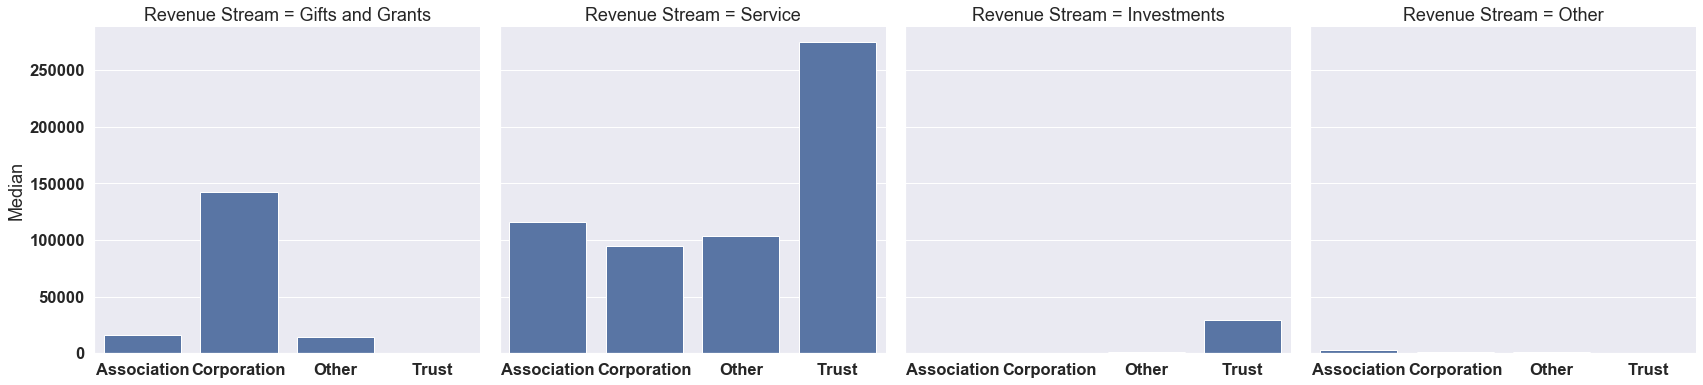

In [15]:
median_rev = grouped_rev[['organization_form', 'Median Gifts and Grants','Median Service','Median Investments','Median Other']].rename(columns={"Median Gifts and Grants": "Gifts and Grants","Median Service": "Service", "Median Investments": "Investments", "Median Other": "Other"})
median_rev=pd.melt(median_rev,id_vars=['organization_form'],var_name='Revenue Stream', value_name='Median')
median_rev

sns.set(font_scale=1.5) 
g = sns.FacetGrid(median_rev, col="Revenue Stream", height = 6, aspect  = 1)
g = g.map(sns.barplot, "organization_form", "Median")
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,2].set_xlabel('')
g.axes[0,3].set_xlabel('')

# Pulling in the full IRS dataset to grab additional details 

we've decided to use the full IRS dataset from here on out. 

https://www.irs.gov/statistics/soi-tax-stats-annual-extract-of-tax-exempt-organization-financial-data

In [16]:
irs_990_raw = pd.read_csv('data/17eofinextract990.dat', sep=' ').clean_names()
# ceaseoperationscd = nonprofit terminated 

# Switching out the column headers
variables = pd.read_excel (r'data/2017variable_switch.xls', sheet_name='990')
col_one_list = variables['Description'].tolist()
irs_990_raw.columns = col_one_list


In [17]:
irs_990 = irs_990_raw

#filter out the organizations that are schools 
isnot_school =  irs_990['School?']== "N"
irs_990 = irs_990[isnot_school]

# Variables to remove 
* ## Part 4 

In [19]:
#Drop variables not valuable for our analysis
irs_990 = irs_990.drop(['E-file indicator',
                                'Described in 501(c)(3)?', #Part 4 begins 
                                'Schedule B required?',
                                'Political activities?',
                                'Lobbying activities?',
                                'Subject to proxy tax?',
                                'Donor advised funds?',
                                'Conservation easements?',
                                'Collections of art?',
                                'Credit counseling?',
                                'Term or permanent endowments?',
                                'Land buildings and equipment reported?',
                                'Investments in other securities reported?',
                                'Program related investments reported?',
                                'Other assets reported?',
                                'Other liabilities reported?',
                                'Separate consolidated financial statement',
                                'Separate audited financial statement',
                                'Included in consolidated financial statements?',
                                'School?',
                                'Foreign office?',
                                'Foreign activities, etc?',
                                'More than $5000 to organizations Part IX, line 3?',
                                'More than $5000 to individuals Part IX, line 3?',
                                'Professional fundraising?',
                                'Fundraising activities?',
                                'Gaming?',
                                'Hospital?',
                                'Hospital audited financial statement included?',
                                'Grants to organizations?',
                                'Grants to individuals?',
                                'Schedule J required?',
                                'Tax exempt bonds?',
                                'Investment income?',
                                'Escrow account?',
                                'On behalf of issuer?',
                                'Excess benefit transaction?',
                                'Prior excess benefit transaction?',
                                'Loan to officer or DQP?',
                                'Grant to related person?',
                                'Business relationship with organization?',
                                'Business relationship thru family member?',
                                'Officer, etc. of entity with business relationship?',
                                'Deductible non-cash contributions?',
                                'Deductible contributions of art, etc?',
                                'Terminated?',
                                'Partial liquidation?',
                                'Disregarded entity?',
                                'Related entity?',
                                'Related organization a controlled entity?',
                                'Any transfers to exempt non-charitable org?',
                                'Activities conducted thru partnership?',
                                'Schedule O completed?'], axis=1)



,Employer Identification Number,Tax period,Subsection code,Number forms transmitted with 1096,Number W-2Gs included in 1a,Compliance with backup withholding?,Number of employees,Employment tax returns filed?,Unrelated business income?,Form 990-T filed?,Foreign financial account?,Prohibited tax shelter transaction?,Taxable party notification?,Form 8886-T filed?,Non-deductible contributions?,Non-deduct. disclosure?,Quid pro quo contributions?,Quid pro quo disclosure?,Form 8282 property disposed of?,Number of 8282s filed,Funds to pay premiums?,Premiums paid?,Form 8899 filed?,Form 1098-C filed?,Excess business holdings?,Taxable distributions?,Distribution to donor?,Initiation fees amount,Gross receipts amount,Gross income from members,Gross income from other sources,Form 990 in lieu of 1041?,Tax exempt interest in lieu of 1041,Qualified health plan in multiple states,Qualified health plan reserves required,Qualified health plan reserves on hand,Payments for indoor tanning,Filed Form 720 for tanning,Reportable compensation from organization,Reportable compensation from related orgs,Other compensation,Number individuals greater than $100K,Number of contractors greater than $100K,Total contributions,Program service revenue code 2a,Program service revenue amount 2a,Program service revenue code 2b,Program service revenue amount 2b,Program service revenue code 2c,Program service revenue amount 2c,Program service revenue code 2d,Program service revenue amount 2d,Program service revenue code 2e,Program service revenue amount 2e,Program service revenue amount 2f,Program service revenue,Investment income,Tax-exempt bond proceeds,Royalties,Gross rents -- Real estate,Gross rents -- Personal property,Rental expense -- Real estate,Rental expense -- Personal property,Net rent -- Real estate,Net rent -- Personal property,Net rental income,Gross sales -- Securities,Gross sales -- Other assets,Sales expense -- Securities,Sales expense -- Other assets,Net gain from sales -- Securities,Net gain from sales -- Other assets,Sales of assets,Gross fundraising,Fundraising expenses,Fundraising income,Gross income from gaming,Gaming expenses,Gaming income,Gross sales of inventory,Cost of goods sold (inventory),Income from sales of inventory,Other revenue code 11a,Other revenue amount 11a,Other revenue code 11b,Other revenue amount 11b,Other revenue code 11c,Other revenue amount 11c,Other revenue amount 11d,Other revenue,Total revenue,Grants to governments/orgs in the US,Grants to individuals in the US,Grants to orgs and individuals outside the US,Benefits paid to or for members,"Compensation of current officers, directors, etc",Compensation of disqualified persons,Other salaries and wages,Pension plan contributions,Other employee benefits,Payroll taxes,Management fees,Legal fees,Accounting fees,Lobbying fees,Professional fundraising fees,Investment management feed,Other fees,Advertising and promotion,Office expenses,Information technology,Royalties,Occupancy,Travel,Travel/entertainment expenses to public officials,"Conferences, conventions, meetings",Interest expense,Payments to affiliates,"Depreciation, depletion, amortization",Insurance,Other expenses 24a,Other expenses 24b,Other expenses 24c,Other expenses 24d,Other expenses 24e,Other expenses 24f,Total functional expenses,Cash -- non-interest bearing -- eoy,Savings and temporary cash investments -- eoy,Pledges and grants receivable -- eoy,Accounts receivable -- eoy,"Receivables from officers, directors, etc. -- eoy",Receivables from disqualified persons -- eoy,Notes and loans receivables -- eoy,Inventories for sale or use -- eoy,Prepaid expenses or deferred charges -- eoy,"Land, buildings, & equipment (net) -- eoy",Investments in publicly traded securities -- eoy,Investments in other securities -- eoy,Program-related investments -- eoy,Intangible assets -- eoy,Other assets -- eoy,Total assets -- eoy,Accounts payable and accrued expenses -- eoy,Grants payable -- eoy,Deferred revenue -- eoy,Tax-exempt bond

# 990 EZ raw data

In [20]:
irs_990EZ_raw = pd.read_csv('data/17eofinextractEZ.dat', sep=' ').clean_names()

irs_990EZ_raw

,elf,ein,taxpd,subseccd,totcntrbs,prgmservrev,duesassesmnts,othrinvstinc,grsamtsalesastothr,basisalesexpnsothr,gnsaleofastothr,grsincgaming,grsrevnuefndrsng,direxpns,netincfndrsng,grsalesminusret,costgoodsold,grsprft,othrevnue,totrevnue,totexpns,totexcessyr,othrchgsnetassetfnd,networthend,totassetsend,totliabend,totnetassetsend,actvtynotprevrptcd,chngsinorgcd,unrelbusincd,filedf990tcd,contractioncd,politicalexpend,filedf1120polcd,loanstoofficerscd,loanstoofficers,initiationfee,grspublicrcpts,s4958excessbenefcd,prohibtdtxshltrcd,nonpfrea,totnoforgscnt,totsupport,gftgrntrcvd170,txrevnuelevied170,srvcsval170,pubsuppsubtot170,excds2pct170,pubsupplesspct170,samepubsuppsubtot170,grsinc170,netincunrelatd170,othrinc170,totsupport170,grsrcptsrelatd170,totgftgrntrcvd509,grsrcptsadmiss509,grsrcptsactvts509,txrevnuelevied509,srvcsval509,pubsuppsubtot509,rcvdfrmdisqualsub509,excds1pct509,subtotpub509,pubsupplesssub509,samepubsuppsubtot509,grsinc509,unreltxincls511tx509,subtotsuppinc509,netincunreltd509,othrinc509,totsupp509
0,Y,421679357,201609,7,0,64066,0,28,0,0,0,0,0,0,0,0,27521,-27521,0,36573,43755,-7182,0,15693,18501,2808,15693,N,N,N,N,N,0,N,N,0,0,0,N,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Y,593097098,201608,3,2346,146962,4462,0,0,0,0,0,0,0,0,0,0,0,0,153770,154430,-660,1635,12270,12270,0,12270,N,N,N,N,N,0,N,N,0,0,0,N,N,7,0,0,665845,0,0,665845,0,665845,665845,0,0,0,665845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Y,946174605,201606,3,9508,5106,1705,0,0,0,0,0,34119,17397,16722,2442,2257,185,0,33226,31516,1710,0,32344,32344,0,32344,N,N,N,N,N,0,N,N,0,0,0,N,N,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11213,41667,0,0,0,52880,0,0,0,52880,52880,0,0,0,0,0,52880
3,Y,900513935,201606,3,14802,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14802,21110,-6308,-900,32588,35753,3165,32588,N,N,N,N,N,0,N,N,0,0,0,N,N,7,0,0,146518,0,0,146518,35000,111518,146518,0,0,3268,149786,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Y,597076178,201609,5,0,0,73263,296,0,0,0,0,0,0,0,0,0,0,1655,75214,71963,3251,0,63731,63731,0,63731,N,N,N,N,N,0,N,N,0,0,0,N,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218092,N,522362749,201606,3,50212,0,1365,0,0,0,0,1620,14890,22513,-6003,0,0,0,6360,51934,61995,-10061,0,8441,8441,0,8441,N,N,N,N,N,0,N,N,0,0,0,N,N,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,163640,144525,0,0,0,308165,0,0,0,309165,308165,26,0,0,0,0,308191
218093,N,454586689,201312,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,N,N,N,N,N,0,N,N,0,0,0,N,N,9,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
218094,N,271354388,201212,3,2736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2736,4110,-1374,0,5083,5083,5083,0,N,N,N,N,N,0,N,N,0,0,0,N,N,7,0,0,124449,0,0,124449,0,124449,124449,0,0,0,124449,2736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218095,N,752143604,201306,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12900,-12900,0,139743,139742,0,139742,N,N,N,N,N,0,N,N,0,0,0,N,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Using the IRSx python package

* https://github.com/jsfenfen/990-xml-reader


In [13]:
import irsx
from irsx.xmlrunner import XMLRunner
# importing libraries we'll use.
import csv
import os
import pandas as pd
import unicodecsv as csv


# This tells us where the csv files are located in the system
from irsx.settings import INDEX_DIRECTORY

In [14]:
#This downloads the index for the year 2017 of all efilers 
%sx irsx_index --verbose --year=2017

['Getting index file for year: 2017 remote=https://s3.amazonaws.com/irs-form-990/index_2017.csv local=c:\\users\\tenis\\anaconda3\\lib\\site-packages\\irsx\\CSV\\index_2017.csv',
 'Beginning streaming download of https://s3.amazonaws.com/irs-form-990/index_2017.csv',
 'Total file size: 59.45 MB',
 'Download completed to c:\\users\\tenis\\anaconda3\\lib\\site-packages\\irsx\\CSV\\index_2017.csv in 0:00:03.670921']

In [21]:
irs2017_index = pd.read_csv("data/index_2017.csv").clean_names()
#irs2017_index = irs2017_index[['taxpayer_name', 'ein', 'object_id','return_type']]

In [22]:
irs2017_index

,return_id,filing_type,ein,tax_period,sub_date,taxpayer_name,return_type,dln,object_id
0,14054169,EFILE,42662873,201603,1/4/2017 10:27:37 AM,ELKS BUILDING CORP OF NORWOOD,990O,93493243000066,201612439349300006
1,14056200,EFILE,42964630,201512,1/4/2017 8:17:38 PM,NEIGHBORHOOD OF AFFORDABLE HOUSING INC,990,93493243000266,201612439349300026
2,14055992,EFILE,382912028,201512,1/4/2017 6:07:44 PM,RELEAF MICHIGAN INC,990,93493243003416,201612439349300341
3,14056203,EFILE,200509226,201605,1/4/2017 8:17:39 PM,ST MICHAEL ALBERTVILLE FOOTBALL BOOSTER CLUB,990,93493243005166,201612439349300516
4,14057332,EFILE,202699020,201512,1/4/2017 11:23:48 PM,KARLA SMITH FOUNDATION,990,93493243005466,201612439349300546
...,...,...,...,...,...,...,...,...,...
489008,15064384,EFILE,272948627,201512,12/29/2017 8:50:35 AM,CONSTELLA FESTIVAL OF MUSIC AND FINE ARTS,990EZ,93492320001487,201733209349200148
489009,15060607,EFILE,200745749,201512,12/28/2017 12:35:11 PM,CHRIST CHURCH INTERNATIONAL INC,990,93493319184457,201703199349318445
489010,15057955,EFILE,263520140,201608,12/27/2017 11:57:28 PM,REBELS SOCCER CLUB,990EZ,93492319074127,201723199349207412
489011,15065145,EFILE,770572762,201707,12/29/2017 12:23:10 PM,RISING FARMWORKER DREAM FUND,990PF,93491317015447,201743179349101544


In [17]:

# read the whole file of orgs with efilings from part 1 here, it's not very long
file_rows = [] 
# We're using the output of part 1
with open("data/index_2017.csv", 'rb') as infile:
    reader = csv.DictReader(infile)
    for row in reader:
        file_rows.append(row)

In [18]:

# the name of the output file
outfilename ="data/employees_simple.csv"
outfile = open(outfilename , 'wb')

# the header rows as they'll appear in the output
headers = ["period", "ein", "object_id", "taxpayer_name", "name", "business_name1", "business_name2", "title", "org_comp", "related_comp"]
# start up a dictwriter, ignore extra rows
dw = csv.DictWriter(outfile, headers, extrasaction='ignore')
dw.writeheader()

In [19]:
# get an XMLRunner -- this is what actually does the parsing
xml_runner = XMLRunner()

In [20]:
DEMO_MAX = 10
num_rows = 0

for row in file_rows:
    num_rows += 1
    this_object_id = row['OBJECT_ID']
    parsed_filing = xml_runner.run_filing(this_object_id)
    
    # if it somehow busted, just note it and continue
    if not parsed_filing:
        print("Skipping filing %s(filings with pre-2013 schemas are skipped)\n row details: %s" % (this_object_id, row))
        continue 
    
    # Is there a Schedule J there at all?
    schedule_list = parsed_filing.list_schedules()
    if 'IRS990ScheduleJ' in schedule_list:
        
        # store the output in this dict
        outputdata = {}
        # assign some initial values from the input csv
        outputdata['period'] = row['TAX_PERIOD_x']
        outputdata['ein'] = row['EIN']
        outputdata['object_id'] = row['OBJECT_ID']
        outputdata['taxpayer_name'] = row['TAXPAYER_NAME']
        
        # some schedules can appear multiple times, but schedule j only appears once
        # so we grab the first one 
        parsed_skedj = parsed_filing.get_parsed_sked('IRS990ScheduleJ')[0] 
        # now use the table name we looked up -- that's where we find it
        try:
            # repeating groups are returned as an array of dicts
            employee_groups = parsed_skedj['groups']['SkdJRltdOrgOffcrTrstKyEmpl']
        except KeyError:
            print("No SkdJRltdOrgOffcrTrstKyEmpl found in %s skipping" % this_object_id)
            continue
          
        # read through each employee and pull out the data we want
        for employee_group in employee_groups:
            
            # That leaves the following values to come from schedule J if there is one
            # "name", "business_name1", "business_name2", "title", "org_comp", "related_comp"
            # those keys come from the headers we gave dictwriter before
            outputdata['name'] = employee_group.get('PrsnNm')
            outputdata['business_name1'] = employee_group.get('BsnssNmLn1Txt')
            outputdata['business_name2'] = employee_group.get('BsnssNmLn2Txt')
            outputdata['title'] = employee_group.get('TtlTxt')
            outputdata['org_comp'] = employee_group.get('TtlCmpnstnFlngOrgAmt') # Part II Column (E) 
            outputdata['related_comp'] = employee_group.get('TtlCmpnstnRltdOrgsAmt')
        
            dw.writerow(outputdata)
        
    else:
        print("No schedule J in filing %s, skipping" % this_object_id)

    # Don't run endlessly during a demo:
    if(num_rows > DEMO_MAX):
        break
    if num_rows%100==0:
        print("Processed %s filings" % num_rows)

No schedule J in filing 201612439349300006, skipping


KeyError: 'TAX_PERIOD_x'

In [13]:
xml_runner = XMLRunner()
parsed_filing = xml_runner.run_filing(201533089349301428)
result = parsed_filing.get_result()  # An array of parsed schedules
schedule_list = parsed_filing.list_schedules() # an array of form names

In [10]:
type(result)

list

In [9]:
import json  # to format output
>>> for sked in result:
...  print("Schedule: %s" % sked['schedule_name'])  
...  print(json.dumps(sked, indent=4, sort_keys=True))   # make json more readable

Schedule: ReturnHeader990x
{
    "csv_line_array": [],
    "groups": {},
    "schedule_name": "ReturnHeader990x",
    "schedule_parts": {
        "returnheader990x_part_i": {
            "BsnssNm_BsnssNmLn1Txt": "SUTTER HEALTH SACRAMENTO SIERRA REGION",
            "BsnssOffcr_DscssWthPdPrprrInd": "true",
            "BsnssOffcr_PhnNm": "9162866665",
            "BsnssOffcr_PrsnNm": "Paige Terra",
            "BsnssOffcr_PrsnTtlTxt": "CFO",
            "BsnssOffcr_SgntrDt": "2015-11-02",
            "Flr_BsnssNmCntrlTxt": "SUTT",
            "Flr_EIN": "941156621",
            "Flr_InCrOfNm": "% CHRIS BOUDREAUX",
            "Flr_PhnNm": "9162866665",
            "PrprrFrmNm_BsnssNmLn1Txt": "ERNST & YOUNG US LLP",
            "PrprrPrsn_PTIN": "P00649485",
            "PrprrPrsn_PhnNm": "8585357200",
            "PrprrPrsn_PrprrPrsnNm": "DEBRA HEISKALA",
            "PrprrUSAddrss_AddrssLn1Txt": "4370 LA JOLLA VILLAGE DR SUITE 500",
            "PrprrUSAddrss_CtyNm": "SAN DIEGO",
     

In [8]:
>>> skedk = parsed_filing.get_parsed_sked('IRS990ScheduleK')
>>> len(skedk)  # Bond schedule fits 4 entries/form; all must be listed

3